<a href="https://colab.research.google.com/github/mille055/AIPI590-XAI/blob/main/Assignments/07_aipi590_xai_explainable_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# AIPI 590 - XAI | Assignment 07

#Description: Explainable Deep Learning

This notebook is for exploring explainable deep AI methods (specifically TCAV) with a hypothesis-driven approach.

## Chad Miller

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mille055/AIPI590-XAI/blob/main/Assignments/07_aipi590_xai_explainabledeeplearning.ipynb)

## Hypothesis and Testing Method:
* Null Hypothesis (H0): The deep learning model does not show a significant difference in the regions of interest, as visualized by saliency maps, between different MRI series types (choosing to compare T2-weighted, T1 pre-contrast, arterial phase, and diffusion-weighted images which should have distinct appearance differences).

* Alternative Hypothesis (H1): The deep learning model shows a significant difference in the regions of interest as visualized by saliency maps between the different MRI series types, focusing on specific anatomical regions.

In exploring this hypothesis, I plan to:


* Generate Saliency Maps: Compute saliency maps using a chosen deep learning model for each MRI series type.
* Create Composite Maps: Create average saliency maps for each series type to identify common regions of interest.
* Quantitative Analysis: Compare the individual and composite saliency maps using structural similarity (SSIM) and Intersection over Union (IoU).
Visual Analysis: Examine visual differences between the average saliency maps using difference heatmaps.




In [1]:

import os

# Remove Colab default sample_data
!rm -r /content/sample_data

# Clone GitHub files to colab workspace
repo_name = "AIPI590-XAI"
git_path = 'https://github.com/mille055/AIPI590-XAI.git'
!git clone "{git_path}"

# Install dependencies from requirements.txt file
!pip install -r "{os.path.join(repo_name,'requirements.txt')}"


notebook_dir = 'Assignments'
path_to_notebook = os.path.join(repo_name,notebook_dir)


Cloning into 'AIPI590-XAI'...
remote: Enumerating objects: 444, done.
remote: Counting objects: 100% (253/253), done.
remote: Compressing objects: 100% (124/124), done.
remote: Total 444 (delta 165), reused 196 (delta 129), pack-reused 191 (from 1)
Receiving objects: 100% (444/444), 101.37 MiB | 29.29 MiB/s, done.
Resolving deltas: 100% (281/281), done.
  Cloning https://github.com/christophM/rulefit.git to /tmp/pip-install-v6dqlinc/rulefit_9c1c1fc3f97a43ccbc4a0c0546f17e5d
  Running command git clone --filter=blob:none --quiet https://github.com/christophM/rulefit.git /tmp/pip-install-v6dqlinc/rulefit_9c1c1fc3f97a43ccbc4a0c0546f17e5d
  Resolved https://github.com/christophM/rulefit.git to commit 472b8574b4eb9e565caf1e05ed580998fe2c9a8e
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/MaximeJumelle/ALEPython.git to /tmp/pip-install-v6dqlinc/alepython_adfa495a639640d5bcb48cf8c6c6a565
  Running command git clone --filter=blob:none --quiet https://github.com/MaximeJume

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
!git clone -b colabversion 'https://github.com/mille055/stanford_project.git'
!git clone 'https://github.com/mille055/AIPI590-XAI.git'
!pip install -r /content/AIPI590-XAI/requirements.txt

Cloning into 'stanford_project'...
remote: Enumerating objects: 2922, done.
remote: Counting objects: 100% (677/677), done.
remote: Compressing objects: 100% (261/261), done.
remote: Total 2922 (delta 477), reused 601 (delta 414), pack-reused 2245 (from 1)
Receiving objects: 100% (2922/2922), 384.51 MiB | 41.90 MiB/s, done.
Resolving deltas: 100% (2077/2077), done.
fatal: destination path 'AIPI590-XAI' already exists and is not an empty directory.
  Cloning https://github.com/christophM/rulefit.git to /tmp/pip-install-kg03rz1r/rulefit_82a22cf44b80467f80ee41475e352e79
  Running command git clone --filter=blob:none --quiet https://github.com/christophM/rulefit.git /tmp/pip-install-kg03rz1r/rulefit_82a22cf44b80467f80ee41475e352e79
  Resolved https://github.com/christophM/rulefit.git to commit 472b8574b4eb9e565caf1e05ed580998fe2c9a8e
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/MaximeJumelle/ALEPython.git to /tmp/pip-install-kg03rz1r/alepython_c54f480fd14a4bf29ca31

In [24]:
## Standard libraries
import json
import math
import time
import numpy as np
import tabulate
import urllib.request
import zipfile
import pandas as pd
import sys
from google.colab import drive
import gdown
import tensorflow as tf

## Imports for data exploration
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

## Imports for linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report


## Imports for logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

## Imports for imodels assignment
from sklearn.datasets import load_diabetes, load_breast_cancer
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier, export_text

## Imports for XGBoost model
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance

## Imports for GAM
from pygam import LogisticGAM, LinearGAM, GammaGAM, s

## Imports for explainable ai
import alibi
from alibi.explainers import AnchorImage
from alibi.explainers import ALE
from skimage.transform import resize
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries
import pdpbox
import warnings
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance
from alepython import ale_plot

## Imports for saliency map evaluation
from skimage.metrics import structural_similarity as ssim
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

## Imports for plotting
from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms, datasets
import torchvision.transforms.functional as TF
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision.datasets import ImageNet


## local imports ###`
sys.path.append('/content/stanford_project/app/scripts/')
from config import file_dict, feats, feats_to_keep, column_lists, RF_parameters, classes, model_paths
from config import abd_label_dict, val_list, train_val_split_percent, random_seed, data_transforms
from utils import *

from cnn.cnn_dataset import ImgDataset
from cnn.cnn_inference import image_to_tensor, pixel_inference, test_pix_model, load_pixel_model, visualize_results
from cnn.cnn_model import *
from cnn.cnn_training import *
from cnn.cnn_data_loaders import get_data_loaders, data_transforms, data_transforms2, data_transforms3, data_transforms4

from model_container import ModelContainer


In [5]:
# get the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Download Datasets and minimal EDA

In [6]:
# get the dataset and model

link = 'https://drive.google.com/drive/folders/1hkuhDngNEf1ogQmnKpT315Ovl9XjotFW?usp=sharing'
gdown.download_folder(link, quiet=False, use_cookies=False)


train_df = pd.read_pickle('/content/mri_series_share/train_df.pkl')
val_df = pd.read_pickle('/content/mri_series_share/val_df.pkl')
test_df = pd.read_pickle('/content/mri_series_share/test_df.pkl')


batch_size = 16
train_loader, val_loader, test_loader, dataset_sizes = get_data_loaders(train_df, val_df, test_df, batch_size)
train_loader2, val_loader2, test_loader2, dataset_sizes2 = get_data_loaders(train_df, val_df, test_df, batch_size, data_transforms=data_transforms2)
train_loader3, val_loader3, test_loader3, dataset_sizes3 = get_data_loaders(train_df, val_df, test_df, batch_size, data_transforms=data_transforms3)
train_loader4, val_loader4, test_loader4, dataset_sizes4 = get_data_loaders(train_df, val_df, test_df, batch_size, data_transforms=data_transforms4)

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataloaders2 = {'train': train_loader2, 'val': val_loader2, 'test': test_loader2}
dataloaders3 = {'train': train_loader3, 'val': val_loader3, 'test': test_loader3}
dataloaders4 = {'train': train_loader4, 'val': val_loader4, 'test': test_loader4}

Retrieving folder contents


Processing file 1Xzot76LHQUw8xgdifbuO8Ghz0SPcMXqs best_model_cnn.pth
Processing file 19Es7b-JMPQxrE7q1dDHRq9vuJyzcdILk test_df.pkl
Processing file 1JQzC27mWJr7M3TiRRMyrSq5qyBkAllBn train_df.pkl
Processing file 1WqAdrAhpA1jd2kZE4Fw94mAYCjH4p938 val_df.pkl


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1Xzot76LHQUw8xgdifbuO8Ghz0SPcMXqs
From (redirected): https://drive.google.com/uc?id=1Xzot76LHQUw8xgdifbuO8Ghz0SPcMXqs&confirm=t&uuid=89128fc3-07e2-411b-8a99-42f22afe3be7
To: /content/mri_series_share/best_model_cnn.pth
100%|██████████| 28.5M/28.5M [00:00<00:00, 128MB/s]
Downloading...
From: https://drive.google.com/uc?id=19Es7b-JMPQxrE7q1dDHRq9vuJyzcdILk
To: /content/mri_series_share/test_df.pkl
100%|██████████| 362k/362k [00:00<00:00, 106MB/s]
Downloading...
From: https://drive.google.com/uc?id=1JQzC27mWJr7M3TiRRMyrSq5qyBkAllBn
To: /content/mri_series_share/train_df.pkl
100%|██████████| 1.15M/1.15M [00:00<00:00, 136MB/s]
Downloading...
From: https://drive.google.com/uc?id=1WqAdrAhpA1jd2kZE4Fw94mAYCjH4p938
To: /content/mri_series_share/val_df.pkl
100%|██████████| 300k/300k [00:00<00:00, 122MB/s]
Download completed


Some things about the dataset:

In [8]:
# list of the classes

cls_list = []
for cls in classes:
    cls_list.append(abd_label_dict[str(cls)]['short'])
print(cls_list)

['adc', 'arterial', 'dynamic_late', 't2', 'dwi', 't2', 'dwi', 'dixon_fat', 'hepatobiliary', 'hepatobiliary', 'in_phase', 'in_phase', 'dynamic_equilibrium', 'loc', 'mrcp', 'opposed_phase', 'opposed_phase', 'portal_venous', 't1_fat_sat']


In [9]:
# distribution of classes in the test dataset
t_df = test_df.copy()
t_df['text_label'] = t_df['label'].apply(lambda x: abd_label_dict[str(x)]['short'])
t_df['text_label'].value_counts()

text_label
t2                     64
arterial               61
t1_fat_sat             47
dwi                    43
dixon_fat              29
mrcp                   28
in_phase               23
opposed_phase          23
dynamic_equilibrium    22
adc                    21
loc                    21
portal_venous          20
dynamic_late           17
hepatobiliary          13
Name: count, dtype: int64

In [7]:
## was hoping this would allow access but cannot use for the datafiles
## due to large number and size of the files
## so have to just mount the gdrive for my use
drive.mount('/content/gdrive')

Mounted at /content/gdrive


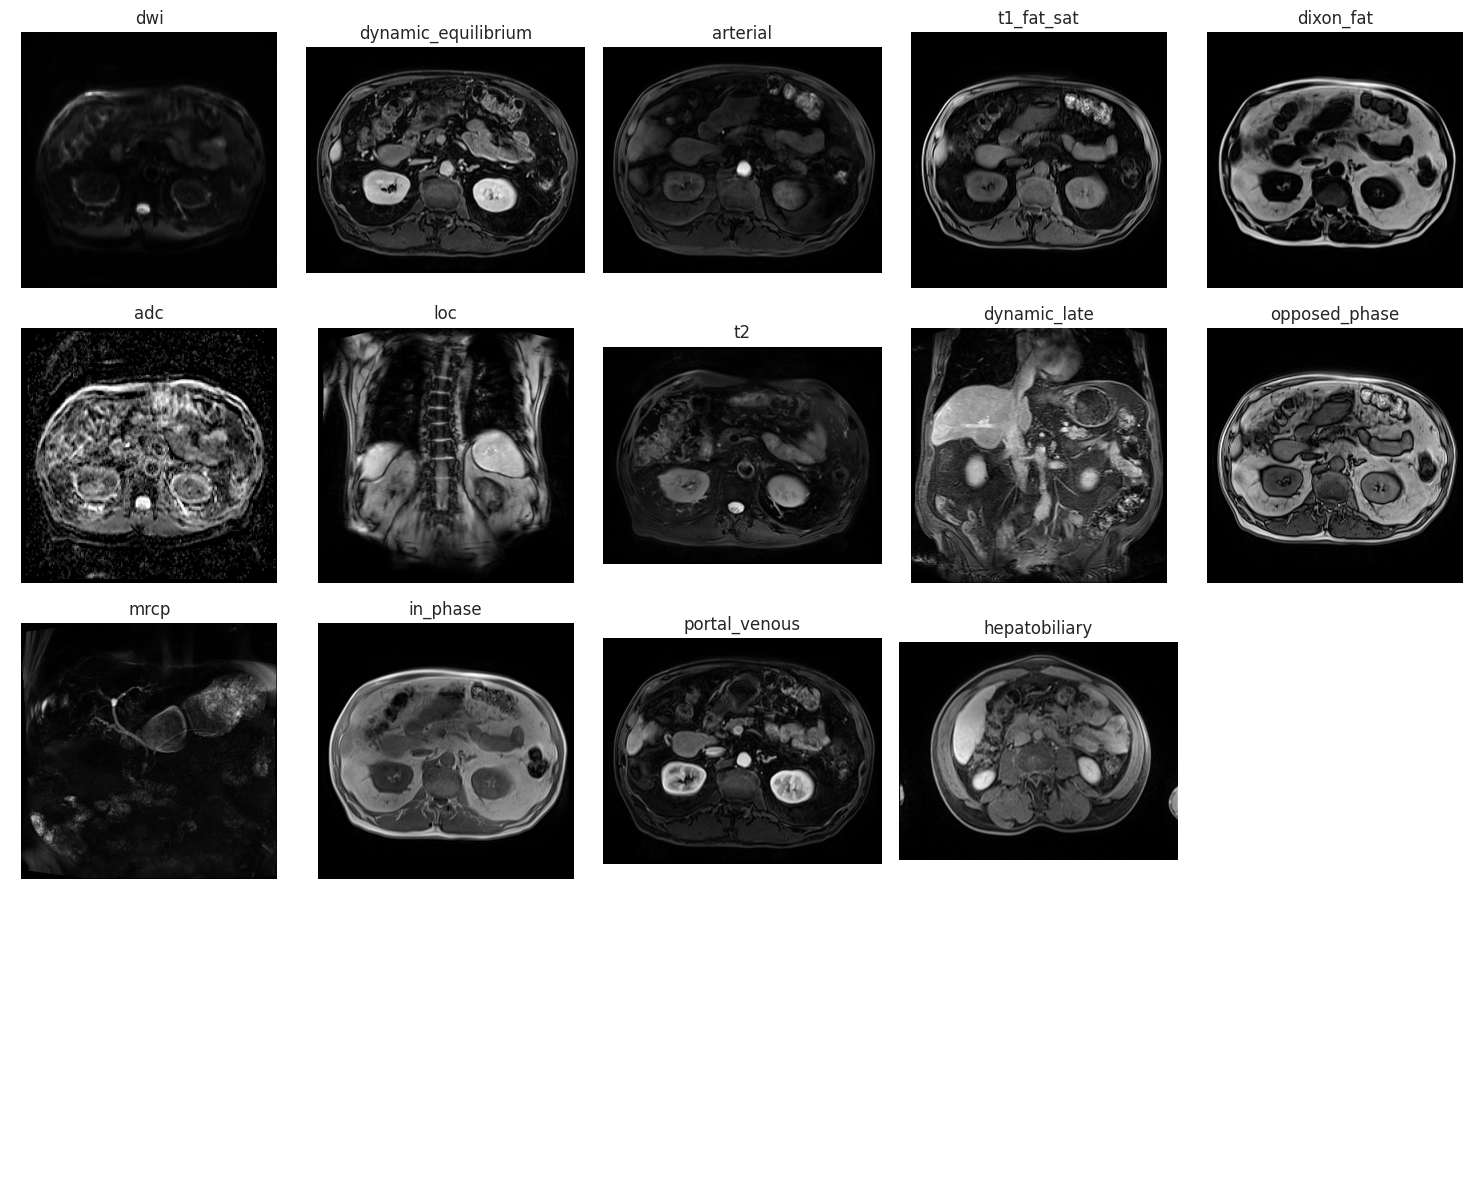

In [10]:
# Get one example of each type of image
each_type = t_df.groupby('text_label').head(1)

# Set up the number of rows and columns for the grid and create a figure
n_cols = 5
n_rows = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 12))

# Flatten the axes for easier indexing
axes = axes.flatten()

# Loop through each image and its corresponding axis
for idx, (ax, (_, row)) in enumerate(zip(axes, each_type.iterrows())):
    image_path = row['fname']
    label = row['label']
    named_label = abd_label_dict[str(label)]['short']

    # Load the DICOM image
    ds = pydicom.dcmread(image_path)
    image = ds.pixel_array

    # Display the image on the corresponding axis
    ax.imshow(image, cmap='gray')
    ax.set_title(named_label)
    ax.axis('off')  # Turn off the axis labels/ticks

# Hide any remaining empty subplots
for ax in axes[idx + 1:]:
    ax.axis('off')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

As you can see above, there are visual differences between the various sequences. I want to compare 4 types: diffusion (dwi), t2-weighted images (t2), t1-pre-contrast (aka t1_fat_sat), and arterial phase post contrast t1 (arterial). These have distinct anatomic differences in general: for example, on t2 and dwi, the fluid in the spinal canal is bright, whereas on the others it is dark; on arterial, the aorta is bright whereas on the others it is not. I aim to compute and compare the saliency maps for these types of images.  




## DenseNet model for image classification

In [13]:
# Load the saved model
model = CustomDenseNet(num_classes=len(classes))
model.load_state_dict(torch.load('/content/mri_series_share/best_model_cnn.pth'))
model.to(device)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 137MB/s]
<ipython-input-13-e3a4d844fada>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly.

CustomDenseNet(
  (densenet): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, mome

## Saliency Maps and Statistical Testing

### Map computation and visual comparison

In [44]:
def compute_saliency_map_pytorch(model, input_image, target_class_idx):
    """ Compute the saliency map for an input image using PyTorch. """
    input_image = input_image.to(next(model.parameters()).device)
    input_image = torch.tensor(input_image, requires_grad=True, dtype=torch.float32)

    # Forward pass to compute predictions
    model.eval()
    output = model(input_image)
    loss = output[0, target_class_idx]

    # Backward pass to compute gradients of the target class score w.r.t. input image
    model.zero_grad()
    loss.backward()

    # Take the absolute value of the gradients
    saliency_map = input_image.grad.data.abs().squeeze().max(dim=0)[0].cpu().numpy()
    return saliency_map

In [45]:
def get_sample_image(df, location):
  """ Get a sample image from the dataframe. """

  example = df.iloc[location]
  image_path = example['fname']
  label = example['label'] # class number 0-31
  model_label = classes.index(label) # the converted label for the 19 classes represented
  named_label = abd_label_dict[str(label)]['short']

  # Load the DICOM image
  ds = pydicom.dcmread(image_path)
  image = ds.pixel_array

  # create transformed image for the model
  transformed_image = image.astype(np.uint8)
  transformed_image = data_transforms2['train'](transformed_image)
  transformed_image = transformed_image.unsqueeze(0)

  # resize image to match that of transformed_image
  image = resize(image, (229, 229))

  return image, transformed_image, model_label, named_label

In [47]:
image, transformed_image, label, named_label = get_sample_image(test_df, 10)

In [48]:

saliency_map = compute_saliency_map_pytorch(model, transformed_image, label)

<ipython-input-44-e4366357cbf4>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_image = torch.tensor(input_image, requires_grad=True, dtype=torch.float32)


In [49]:
def plot_saliency(image, labelname, saliency_map):
    """ Plot original image and its saliency map side-by-side using PyTorch. """
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))


    axes[0].imshow(image, cmap='gray')
    axes[0].set_title(f"Original Image of class {labelname} ")
    axes[0].axis('off')

    # # Plot the saliency map
    axes[1].imshow(saliency_map, cmap='hot')
    axes[1].set_title("Saliency Map")
    axes[1].axis('off')

    plt.show()

<ipython-input-44-e4366357cbf4>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_image = torch.tensor(input_image, requires_grad=True, dtype=torch.float32)


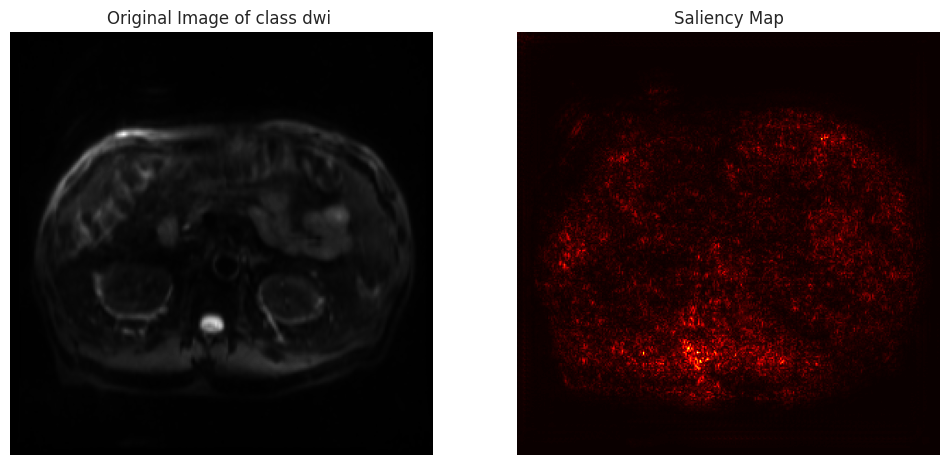

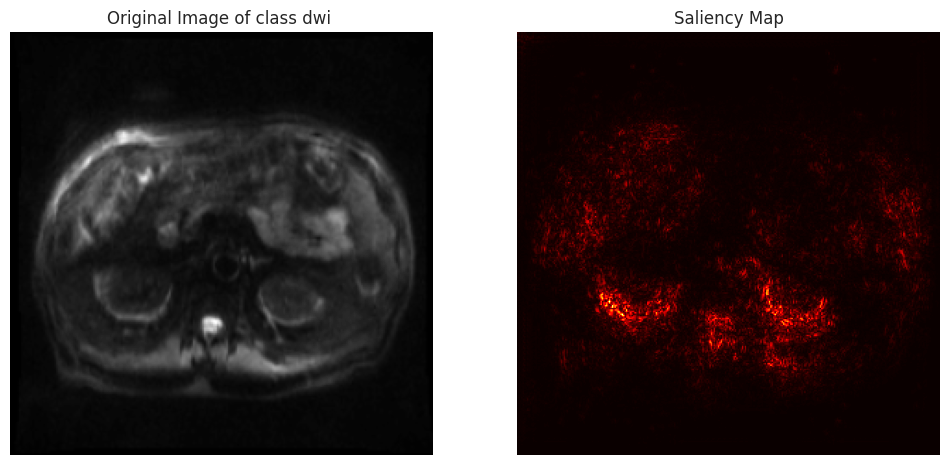

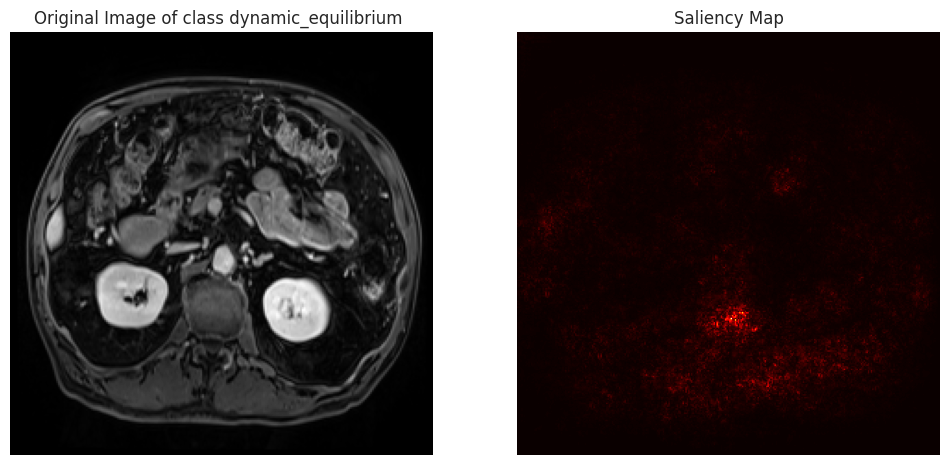

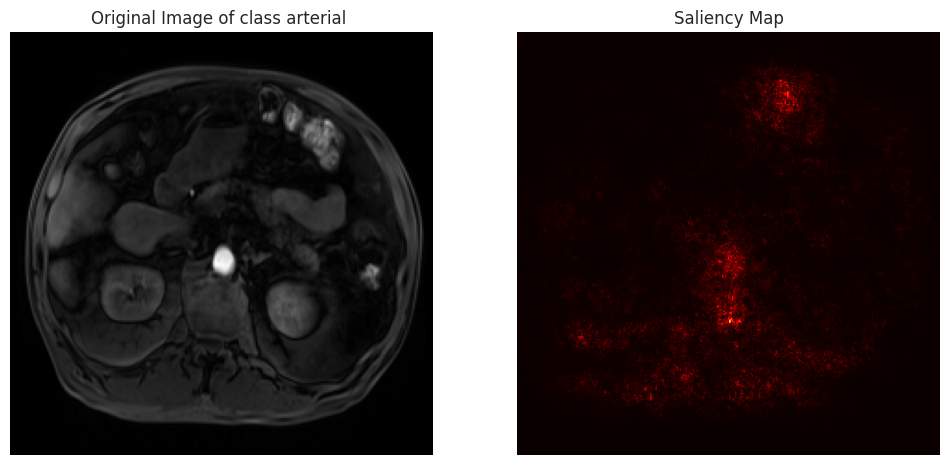

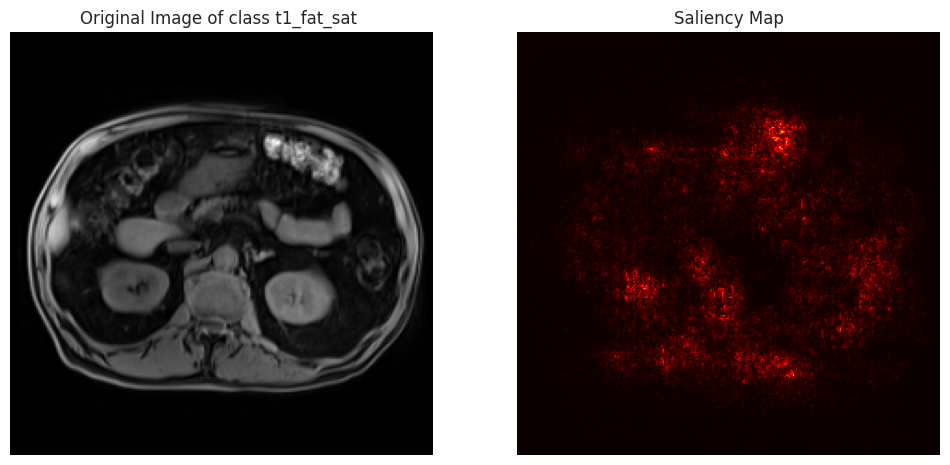

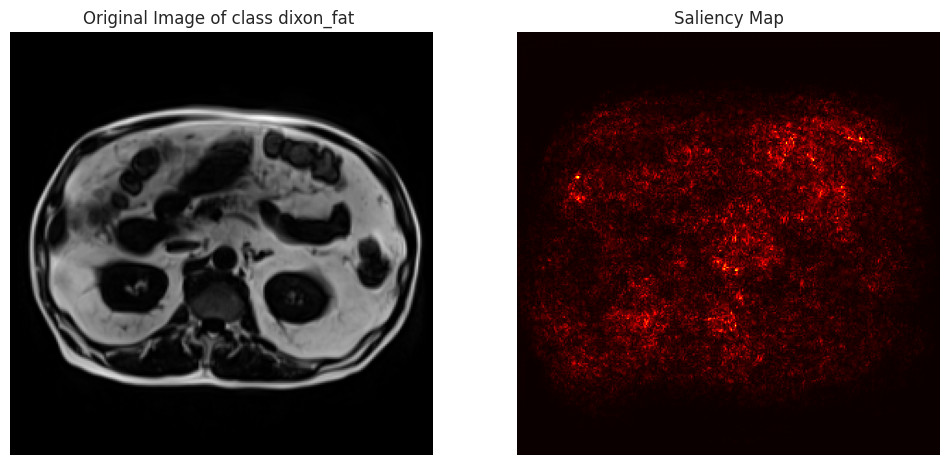

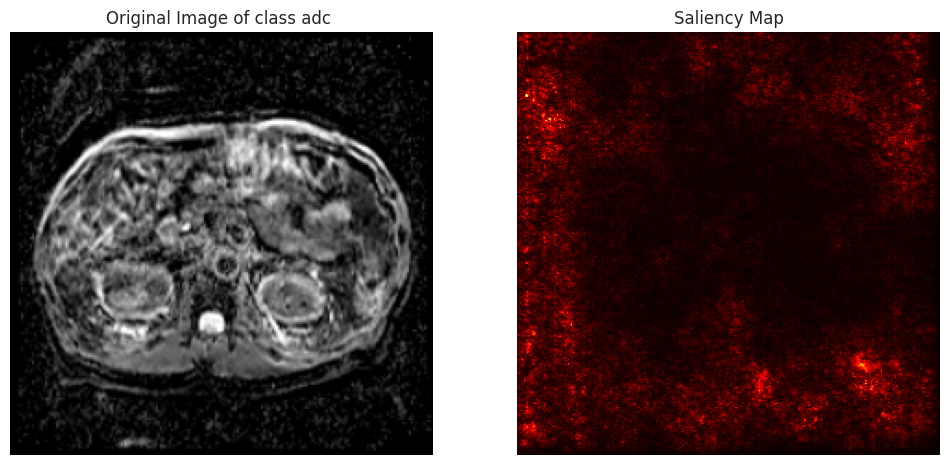

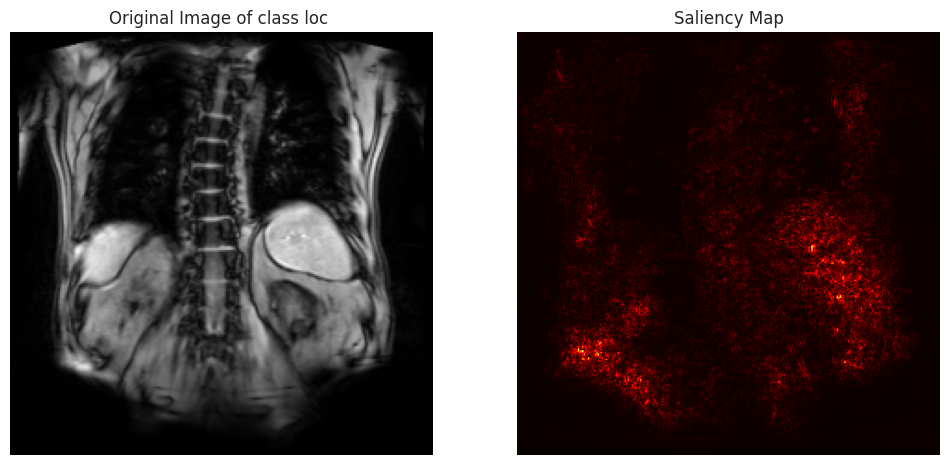

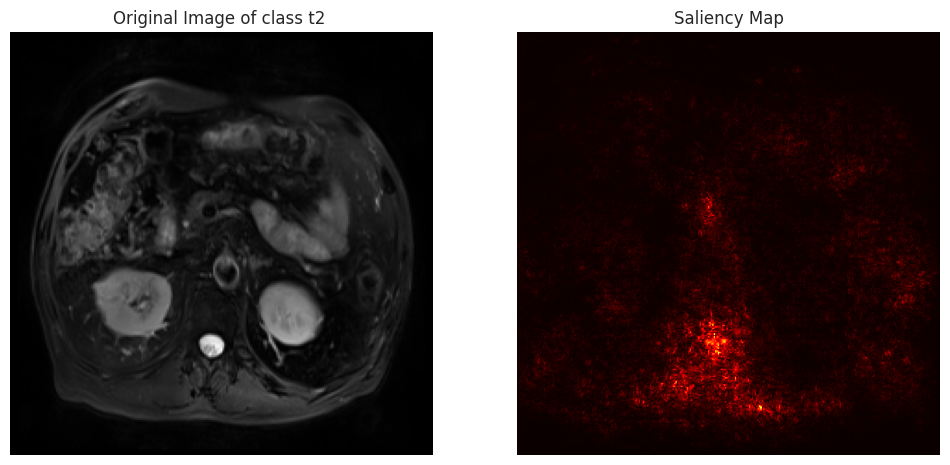

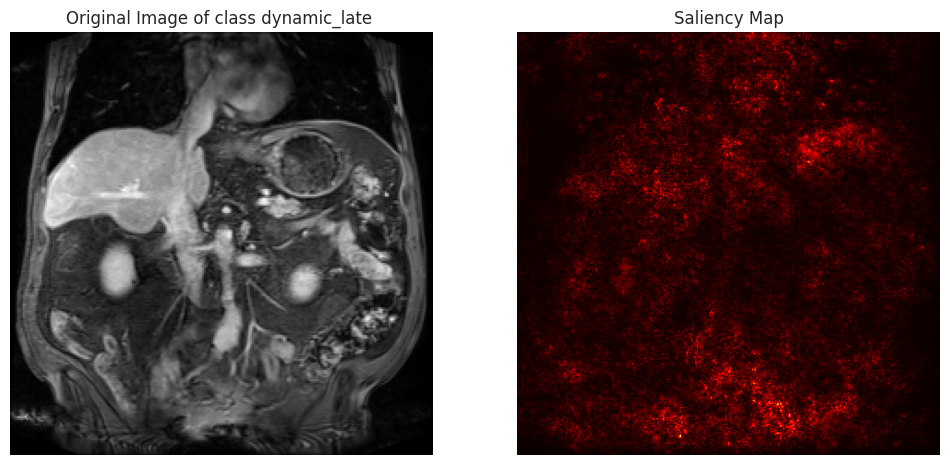

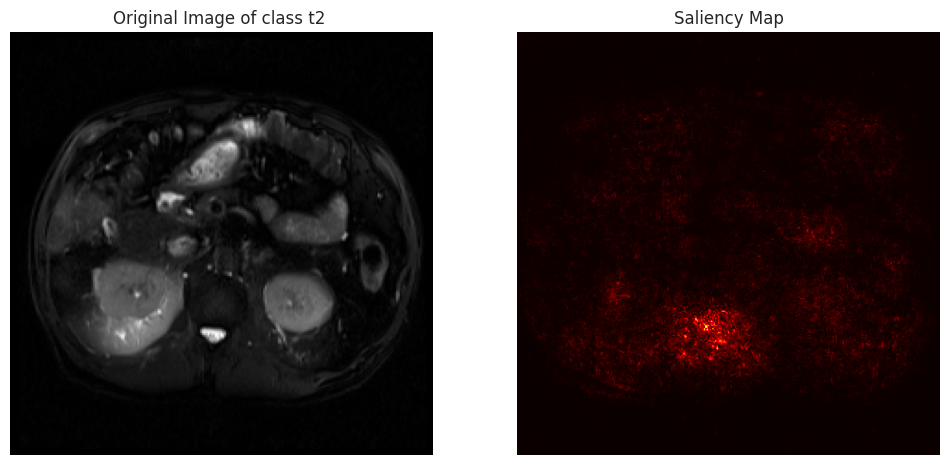

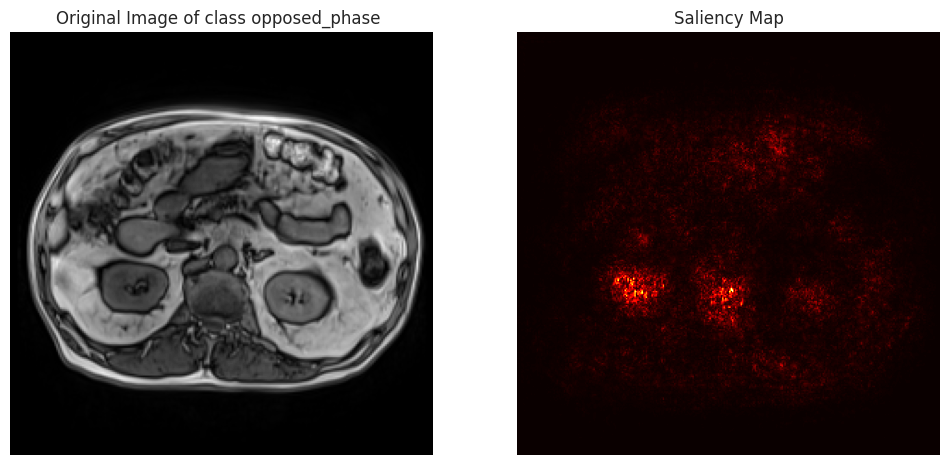

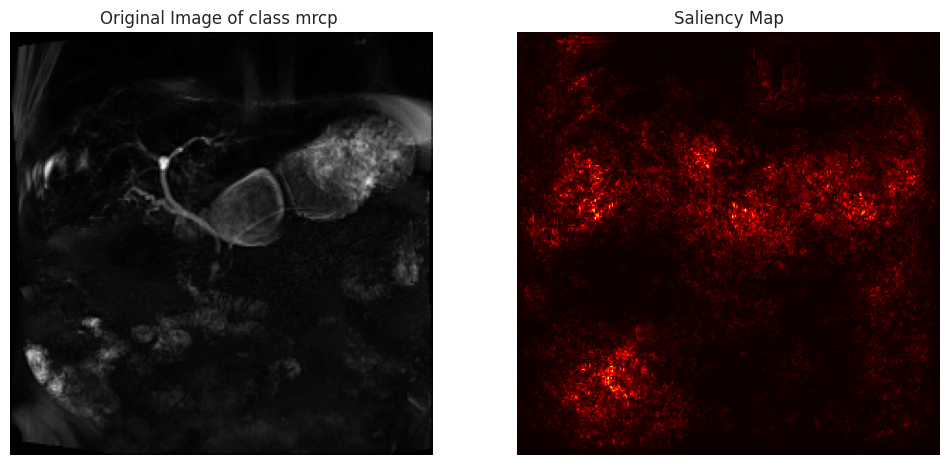

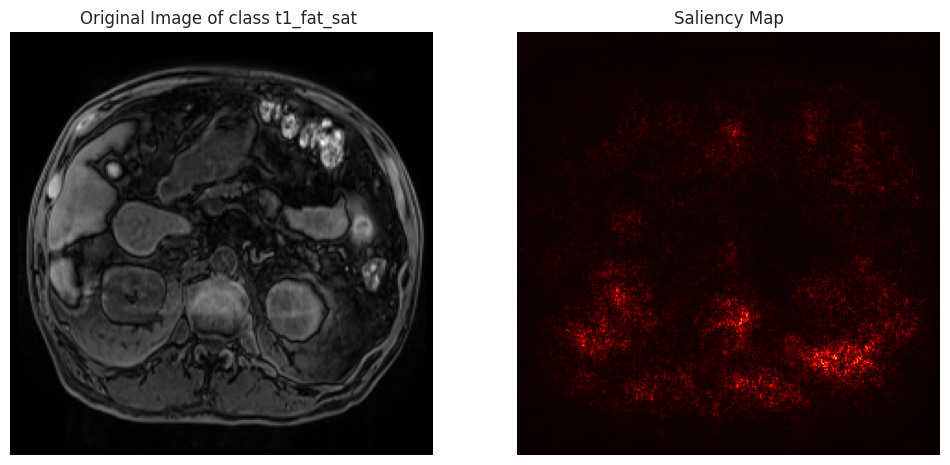

In [50]:
# show an example from each class
for i in range(each_type.shape[0]):
  image, transformed_image, label, named_label = get_sample_image(test_df, i)
  saliency_map = compute_saliency_map_pytorch(model, transformed_image, label)
  plot_saliency(image, named_label, saliency_map)

It would appear on some of these maps that the focus is in different geographic regions, and specifically that for the t2 map the region of the spinal canal shows activity; these particular dwi images do not appear to show the same distribution. For the arterial image, there is some focus on the aorta, but also on a random loop of bowel in the anterior abdomen. In general, these do not appear to be as focused on the areas that a human expert would focus on when classifying the images.

## Quantitative assessment and hypothesis testing

In [51]:
def calculate_ssim(map1, map2):
    """ Calculate Structural Similarity Index (SSIM) between two saliency maps. """
    # Ensure both maps are normalized and have the same dimensions
    map1_norm = (map1 - np.min(map1)) / (np.max(map1) - np.min(map1))
    map2_norm = (map2 - np.min(map2)) / (np.max(map2) - np.min(map2))

    # Compute SSIM (range: -1 to 1, where 1 indicates identical images)
    score, _ = ssim(map1_norm, map2_norm, full=True)
    return score


In [52]:
def calculate_iou(map1, map2, threshold=0.5):
    """ Calculate Intersection over Union (IoU) between two saliency maps. """
    # Create binary masks based on the threshold
    binary_map1 = (map1 > threshold).astype(int)
    binary_map2 = (map2 > threshold).astype(int)

    # Calculate intersection and union
    intersection = np.sum(binary_map1 * binary_map2)
    union = np.sum(binary_map1) + np.sum(binary_map2) - intersection

    iou = intersection / union if union != 0 else 0
    return iou

In [53]:
def cluster_saliency_maps(saliency_maps, n_clusters=3):
    """ Perform PCA and K-means clustering on a set of saliency maps. """
    # Flatten each saliency map into a 1D array
    flattened_maps = [saliency_map.flatten() for saliency_map in saliency_maps]

    # Perform PCA for dimensionality reduction
    pca = PCA(n_components=10)
    reduced_maps = pca.fit_transform(flattened_maps)

    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters)
    labels = kmeans.fit_predict(reduced_maps)
    return labels

In [54]:
def compute_saliency_for_row(index, df, model):
    """ Compute and return the saliency map for a given row in the DataFrame. """
    # Get the necessary data from the row
    image, transformed_image, model_label, named_label = get_sample_image(
        df, index)

    # Compute the saliency map
    saliency_map = compute_saliency_map_pytorch(model, transformed_image, model_label)

    return saliency_map

In [79]:
## create the saliency dataframe which contains all the maps
## in combination with the labels and other data from the
## test dataframe

saliency_df = test_df.copy()
saliency_df['saliency_map'] = saliency_df.index.to_series().apply(
    lambda row: compute_saliency_for_row(row, saliency_df, model))



<ipython-input-44-e4366357cbf4>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_image = torch.tensor(input_image, requires_grad=True, dtype=torch.float32)


In [87]:
## create comparison dataframes for the specific groups
t2_weighted_images = saliency_df[saliency_df['label'] == 9]
t1_precontrast_images = saliency_df[saliency_df['label'] == 25]
diffusion_images = saliency_df[saliency_df['label'] == 8]
arterial_images = saliency_df[saliency_df['label'] == 2]

print(f"Found {len(t2_weighted_images)} T2 weighted images.")
print(f"Found {len(t1_precontrast_images)} T1 precontrast images.")
print(f"Found {len(diffusion_images)} diffusion weighted images.")
print(f"Found {len(arterial_images)} arterial images.")

Found 42 T2 weighted images.
Found 47 T1 precontrast images.
Found 43 diffusion weighted images.
Found 61 arterial images.


First, I'll look at average ssim and iou calculations for pairs of types of images (ie, comparing the average values obtained by comparing each individual example in each of the two groups)

In [107]:
def calculate_average_ssim(df1, df2, data_range=1.0):
    """ Calculate the average SSIM between all pairs of saliency maps from two different DataFrames. """
    ssim_scores = []
    for map1 in df1['saliency_map']:
        for map2 in df2['saliency_map']:
            # Ensure that both maps are normalized and have the same dimensions
            score, _ = ssim(map1, map2, full=True, data_range=data_range)
            ssim_scores.append(score)

    mean_ssim = np.mean(ssim_scores)
    std_ssim = np.std(ssim_scores)

    return mean_ssim, std_ssim



In [90]:
def calculate_average_iou(df1, df2, threshold=0.5):
    """ Calculate the average IoU between all pairs of saliency maps from two different DataFrames. """
    iou_scores = []
    for map1 in df1['saliency_map']:
        for map2 in df2['saliency_map']:
            # Create binary masks based on the threshold
            binary_map1 = (map1 > threshold).astype(int)
            binary_map2 = (map2 > threshold).astype(int)

            # Calculate intersection and union
            intersection = np.sum(binary_map1 * binary_map2)
            union = np.sum(binary_map1) + np.sum(binary_map2) - intersection
            iou = intersection / union if union != 0 else 0
            iou_scores.append(iou)

    return np.mean(iou_scores)

In [108]:
# compare average ssim values amongst the t2, t1, and diffusion images
average_ssim_t2_dwi, std_ssim_t2_dwi = calculate_average_ssim(t2_weighted_images, diffusion_images)
average_ssim_t2_t1, std_ssim_t2_t1 = calculate_average_ssim(t1_precontrast_images, t2_weighted_images)
average_ssim_dwi_t1, std_ssim_dwi_t1 = calculate_average_ssim(diffusion_images, t1_precontrast_images)
average_ssim_t2_arterial, std_ssim_t2_arterial = calculate_average_ssim(t2_weighted_images, arterial_images)


print(f"Average SSIM between T2-weighted and DWI: {average_ssim_t2_dwi} with STD {std_ssim_t2_dwi}")
print(f"Average SSIM between T1-precontrast and T2-weighted: {average_ssim_t2_t1} with STD {std_ssim_t2_t1}")
print(f"Average SSIM between DWI and T1-precontrast: {average_ssim_dwi_t1} with STD {std_ssim_dwi_t1}")
print(f"Average SSIM between T2-weighted and arterial: {average_ssim_t2_arterial} with STD {std_ssim_t2_arterial}")


Average SSIM between T2-weighted and DWI: 0.9880235346342379 with STD 0.006003471798956328
Average SSIM between T1-precontrast and T2-weighted: 0.9771039831622433 with STD 0.012142523369098778
Average SSIM between DWI and T1-precontrast: 0.9775476097135535 with STD 0.014712804950707915
Average SSIM between T2-weighted and arterial: 0.9747394075835972 with STD 0.010189348676065463


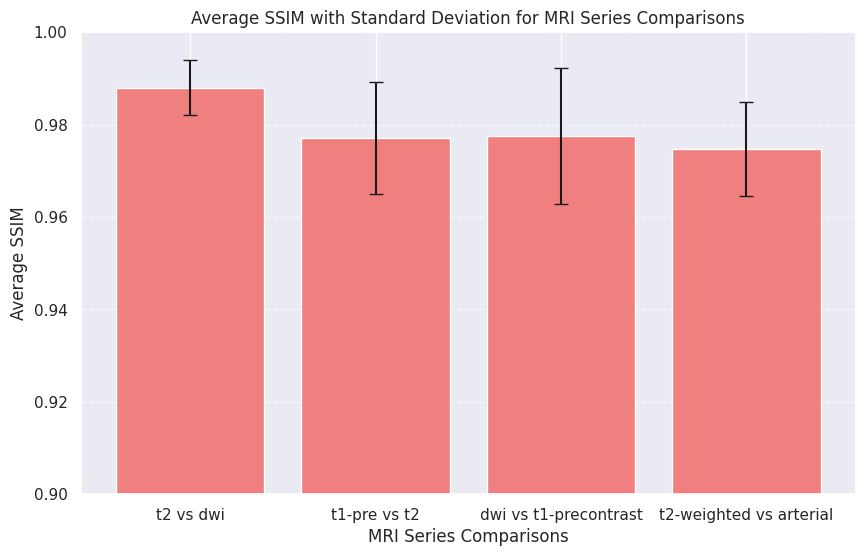

In [110]:
## plotting this data as well:
comparisons = ['t2 vs dwi', 't1-pre vs t2',
               'dwi vs t1-precontrast', 't2-weighted vs arterial']
average_ssim_values = [average_ssim_t2_dwi, average_ssim_t2_t1, average_ssim_dwi_t1, average_ssim_t2_arterial]
std_ssim_values = [std_ssim_t2_dwi, std_ssim_t2_t1, std_ssim_dwi_t1, std_ssim_t2_arterial]

# Plot all average SSIM values and standard deviations in one plot
plt.figure(figsize=(10, 6))

# Create a bar plot with error bars representing standard deviation
plt.bar(comparisons, average_ssim_values, yerr=std_ssim_values, capsize=5, color='lightcoral')
plt.title('Average SSIM with Standard Deviation for MRI Series Comparisons')
plt.ylabel('Average SSIM')
plt.xlabel('MRI Series Comparisons')
plt.ylim(0.9, 1.0)  # Set the y-axis limit for SSIM range (based on your data)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()

In [91]:
iou_scores_t2_t1 = calculate_average_iou(t2_weighted_images, t1_precontrast_images)
iou_scores_t2_dwi = calculate_average_iou(t2_weighted_images, diffusion_images)
iou_scores_dwi_t1 = calculate_average_iou(diffusion_images, t1_precontrast_images)
iou_scores_t2_arterial = calculate_average_iou(t2_weighted_images, arterial_images)

print(f"Average IoU between T2-weighted and T1-precontrast: {iou_scores_t2_t1}")
print(f"Average IoU between T2-weighted and DWI: {iou_scores_t2_dwi}")
print(f"Average IoU between DWI and T1-precontrast: {iou_scores_dwi_t1}")
print(f"Average IoU between T2-weighted and arterial: {iou_scores_t2_arterial}")


Average IoU between T2-weighted and T1-precontrast: 0.0
Average IoU between T2-weighted and DWI: 0.0
Average IoU between DWI and T1-precontrast: 0.0
Average IoU between T2-weighted and arterial: 0.0


We observe that the average SSIM values for each comparison is quite high and in a tight range (0.974 to 0.988). The highest value is for the t2 and diffusion (dwi) groups, which makes sense. However, suspect that these are not statistically significant differences given the error bars.

The average IoU values are all quite low, suggesting that the

Based on these SSIM and IoU values alone, there is insufficient evidence to support the alternative hypothesis (H1) that the model’s focus differs significantly between MRI series types.

Next, I will look qualitatively at the composite saliency map within each group, as well as comparison of these composite maps amongst groups:

In [92]:
def calculate_average_iou_within(df, threshold=0.1):
    """ Calculate the average IoU between all pairs of saliency maps within the same DataFrame. """
    iou_scores = []
    num_maps = len(df['saliency_map'])

    # Compare each pair of saliency maps within the DataFrame
    for i in range(num_maps):
        for j in range(i + 1, num_maps):
            map1 = df['saliency_map'].iloc[i]
            map2 = df['saliency_map'].iloc[j]

            # Create binary masks based on the threshold
            binary_map1 = (map1 > threshold).astype(int)
            binary_map2 = (map2 > threshold).astype(int)

            # Calculate intersection and union
            intersection = np.sum(binary_map1 * binary_map2)
            union = np.sum(binary_map1) + np.sum(binary_map2) - intersection
            iou = intersection / union if union != 0 else 0
            iou_scores.append(iou)

    return np.mean(iou_scores)


In [94]:
def create_average_saliency_map(df):
    """ Create an average saliency map from all saliency maps in the DataFrame. """
    # Stack all saliency maps along a new axis (axis=0) to create a 3D array
    saliency_stack = np.stack(df['saliency_map'].values)

    # Calculate the mean along the new axis to create the average saliency map
    average_saliency_map = np.mean(saliency_stack, axis=0)

    return average_saliency_map

def plot_average_saliency_map(average_saliency_map, title="Average Saliency Map"):
    """ Plot the average saliency map. """
    plt.figure(figsize=(8, 6))
    plt.imshow(average_saliency_map, cmap='hot')
    plt.title(title)
    plt.axis('off')
    plt.colorbar()
    plt.show()


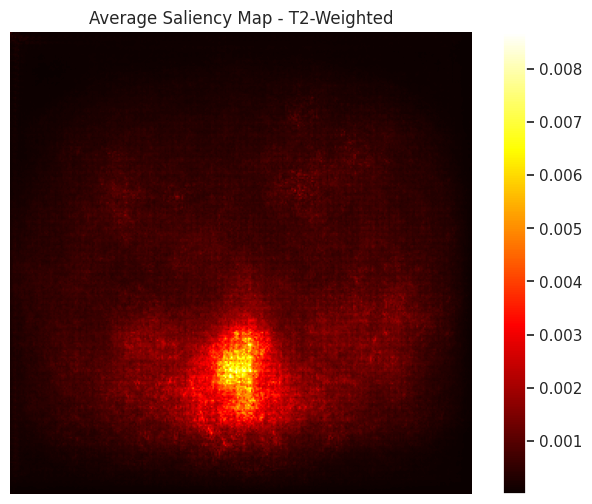

In [95]:
average_saliency_t2 = create_average_saliency_map(t2_weighted_images)
plot_average_saliency_map(average_saliency_t2, title="Average Saliency Map - T2-Weighted")


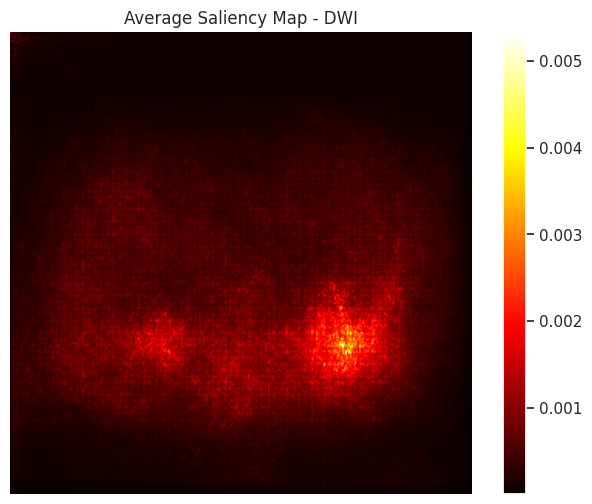

In [96]:
average_saliency_dwi = create_average_saliency_map(diffusion_images)
plot_average_saliency_map(average_saliency_dwi, title="Average Saliency Map - DWI")



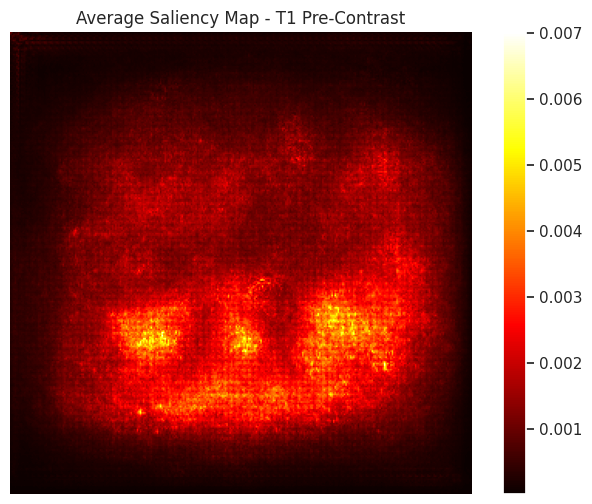

In [98]:
average_saliency_t1_pre = create_average_saliency_map(t1_precontrast_images)
plot_average_saliency_map(average_saliency_t1_pre, title="Average Saliency Map - T1 Pre-Contrast")

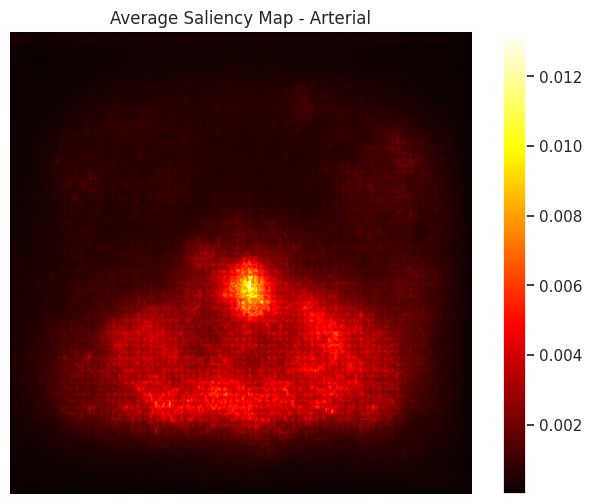

In [99]:
average_saliency_arterial = create_average_saliency_map(arterial_images)
plot_average_saliency_map(average_saliency_arterial, title="Average Saliency Map - Arterial")


Qualitatively, these composite images make some sense with regards to the anatomic regions of interest. Specifically, the arterial composite shows focus on the aorta predominantly whereas the t2 composite shows focus on the spinal canal. The other two groups make less sense--the diffusion (dwi) and t1-precontrast images have some distribution around the kidneys but not other anatomic regions that highlight the visual differences between groups.  

In [100]:
def compare_average_ssim(map1, map2, data_range=1.0):
    """ Calculate the SSIM between two average saliency maps. """
    score, _ = ssim(map1, map2, full=True, data_range=data_range)
    return score

In [101]:
average_ssim_t2_dwi = compare_average_ssim(average_saliency_t2, average_saliency_dwi, data_range=1.0)
print(f"SSIM between T2-weighted and DWI average saliency maps: {average_ssim_t2_dwi}")

SSIM between T2-weighted and DWI average saliency maps: 0.9961701572621092


In [102]:
average_ssim_t2_t1 = compare_average_ssim(average_saliency_t2, average_saliency_t1_pre, data_range=1.0)
print(f'SSIM between T1-weighted precontrast images and T2-weighted images average saliency maps: {average_ssim_t2_t1}' )

SSIM between T1-weighted precontrast images and T2-weighted images average saliency maps: 0.9942504232029119


In [103]:
def compare_average_mse(map1, map2):
    """ Calculate the Mean Squared Error (MSE) between two average saliency maps. """
    mse = np.mean((map1 - map2) ** 2)
    return mse

In [114]:
average_mse_t2_dwi = compare_average_mse(average_saliency_t2, average_saliency_dwi)
print(f"MSE between T2-weighted and DWI average saliency maps: {average_mse_t2_dwi}")

average_mse_t2_t1 = compare_average_mse(average_saliency_t2, average_saliency_t1_pre)
print(f"MSE between T2-weighted and T1-precontrast average saliency maps: {average_mse_t2_t1}")

average_mse_t2_arterial = compare_average_mse(average_saliency_t2, average_saliency_arterial)
print(f"MSE between T2-weighted and arterial average saliency maps: {average_mse_t2_arterial}")

average_mse_t1_arterial = compare_average_mse(average_saliency_t1_pre, average_saliency_arterial)
print(f"MSE between T1-precontrast and arterial average saliency maps: {average_mse_t1_arterial}")

MSE between T2-weighted and DWI average saliency maps: 4.559498449907551e-07
MSE between T2-weighted and T1-precontrast average saliency maps: 6.716152256558416e-07
MSE between T2-weighted and arterial average saliency maps: 1.1531211612236802e-06
MSE between T1-precontrast and arterial average saliency maps: 5.803977387586201e-07


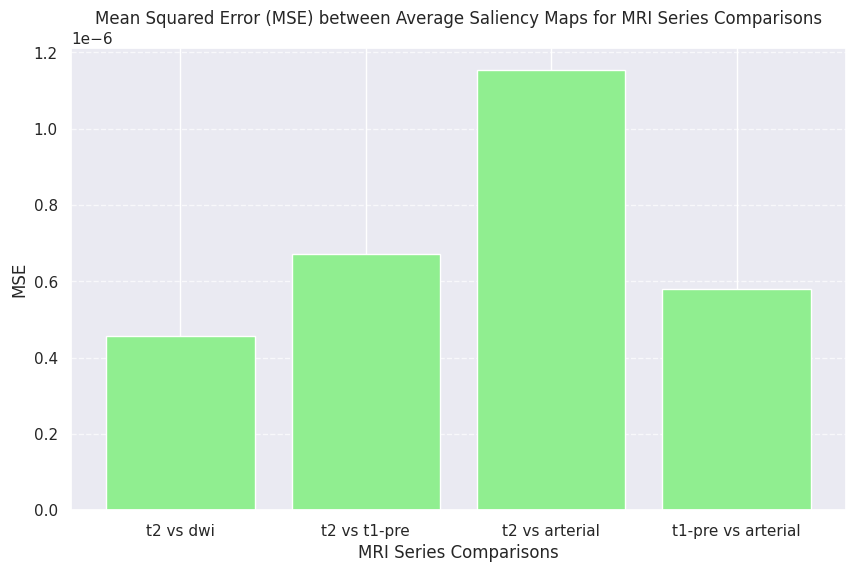

In [116]:
# Example MSE values from the previous comparison results
mse_comparisons = ['t2 vs dwi', 't2 vs t1-pre',
                   't2 vs arterial', 't1-pre vs arterial']
average_mse_values = [average_mse_t2_dwi, average_mse_t2_t1, average_mse_t2_arterial, average_mse_t1_arterial]

# Plot MSE values for different comparisons
plt.figure(figsize=(10, 6))
plt.bar(mse_comparisons, average_mse_values, color='lightgreen')
plt.title('Mean Squared Error (MSE) between Average Saliency Maps for MRI Series Comparisons')
plt.ylabel('MSE')
plt.xlabel('MRI Series Comparisons')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()

Some initial attempts to compare the composite saliency maps between the groups does not show helpful differences in the case of comparing ssim betwen t2-dwi and t2-t1. In the icomparison of MSE between the composite saliency maps, the trends of lowest error for t2 versus dwi and for t1-pre versus arterial make some intuitive sense.

## Analysis and Summary
While several of the saliency maps, upon visual inspection, show some expected focus on anatomical regions that are important for human expert classification, the overall quantitative results were less conclusive, and the alternative hypothesis was not proven.

Specifically, the average SSIM values when comparing the saliency maps across different MRI series types (such as T2-weighted vs. DWI, T2-weighted vs. T1-precontrast, etc.) consistently showed high structural similarity, with values ranging between 0.97 and 0.99. These high SSIM scores indicate that the model's regions of interest are largely overlapping between the different MRI series types. Although standard deviations were relatively low, suggesting consistency in the model's focus within each series type, the lack of substantial differences in SSIM values points to a more generalized focus across the MRI series. This also carried over to the results for the composite images made for each group of similar series type; while the visual analysis of the composite saliency maps highlighted certain anatomic regions, the quantitative comparison using SSIM did not show differences amongst the groups and therefore the null hypothesis is not rejected.

## Implications and Future Directions:
Although the visual inspection of some saliency maps showed promising focus on anatomically relevant regions, the lack of quantitative differentiation suggests potential areas for improvement:

* use alternative or additional metrics beyond SSIM such as feature-based similarity measures to capture more nuanced differences in saliency maps.
* further explore MSE of the composite saliency maps as initial evaluation shows reasonable trends.
* quantitatively compare the details in the original images with respect to hyperintensity (brightness) and anatomical regions is to analyze the alignment between these characteristics and the regions highlighted by the saliency maps. This approach could provide a clearer evaluation of whether the model's regions of emphasis correspond to clinically relevant anatomical structures and hyperintense areas. By establishing a more direct correlation between the model's focus and key image features, we can better assess the model's interpretability and its ability to capture clinically significant patterns.